<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="25%"/>
  </p>
  
# **Trabajo Práctico 2: Críticas Cinematográficas**
### **Grupo**: 11 - Los Pandas 🐼
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo Suster
### **Integrantes**:
- ### 106861 - Labollita, Francisco
- ### 102312 - Mundani Vegega, Ezequiel
- ###  97263 - Otegui, Matías Iñaki

# Modelo Bayes Naive

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline


In [84]:
reviews = pd.read_csv('train.csv')

## Entrenamiento del modelo

Primero se ve cuál es el mejor tipo de clasificador para el modelo, se prueba con Bernoulli, Multinomial y Gaussiano. Luego se optimizan sus hiperparámetros.

In [86]:
reviews_x = reviews['review_es'].copy()
reviews_y = reviews['sentimiento'].copy()

x_train, x_test, y_train, y_test = train_test_split(reviews_x, reviews_y, test_size=0.30, random_state=0)

In [87]:
classifiers = [
    MultinomialNB(),
    ComplementNB(),
    BernoulliNB(),
]

vectorizers = [
    CountVectorizer(),
    TfidfVectorizer()
]

for v in vectorizers:
    for c in classifiers:
        model = make_pipeline(v, c)

        model.fit(x_train, y_train)

        predicted_categories = model.predict(x_test)

        print("Para", v, ",", c, "la precision es", round(accuracy_score(y_test, predicted_categories), 4))

Para CountVectorizer() , MultinomialNB() la precision es 0.8393
Para CountVectorizer() , ComplementNB() la precision es 0.8391
Para CountVectorizer() , BernoulliNB() la precision es 0.8469
Para TfidfVectorizer() , MultinomialNB() la precision es 0.8568
Para TfidfVectorizer() , ComplementNB() la precision es 0.8567
Para TfidfVectorizer() , BernoulliNB() la precision es 0.8469


## Análisis del mejor modelo entrenado

Se obtuvo que el mejor modelo es un CountVectorizer con clasificador multinomial.

In [88]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)


Matriz de confusión de los datos de prueba:


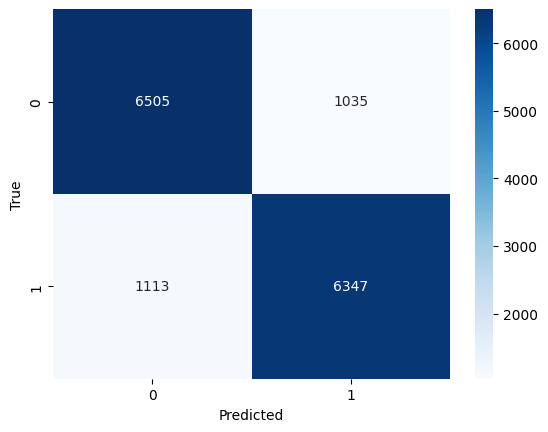

In [89]:
y_train_bool = (y_train == 'positivo').astype(int)
y_train_pred_bool = (y_train_pred == 'positivo').astype(int)
y_test_bool = (y_test == 'positivo').astype(int)
y_test_pred_bool = (y_test_pred == 'positivo').astype(int)

train_score = f1_score(y_train_bool.values, y_train_pred_bool)
test_score = f1_score(y_test_bool.values, y_test_pred_bool)

print("Matriz de confusión de los datos de prueba:")
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [90]:
accuracy=accuracy_score(y_train_bool, y_train_pred_bool)
recall=recall_score(y_train_bool, y_train_pred_bool)
f1=f1_score(y_train_bool, y_train_pred_bool)
precision=precision_score(y_train_bool, y_train_pred_bool)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

accuracy=accuracy_score(y_test_bool,y_test_pred_bool)
recall=recall_score(y_test_bool,y_test_pred_bool)
f1=f1_score(y_test_bool,y_test_pred_bool)
precision=precision_score(y_test_bool,y_test_pred_bool)

print("\nCálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.914
Recall:  0.905
Precision:  0.921
F1 score:  0.913

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.857
Recall:  0.851
Precision:  0.86
F1 score:  0.855


## Grid Search

In [91]:
model = Pipeline([("tfidf", TfidfVectorizer()), ("mnb", MultinomialNB())])

params_grid = {
        'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
        'tfidf__max_features': [1000, 10000, 100000],
        'mnb__alpha': [0.001, 0.01, 0.1],
}

scorer_fn = make_scorer(f1_score, pos_label='positivo')
kfoldcv = StratifiedKFold(n_splits=5)

gridcv = GridSearchCV(estimator=model,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv
                      )

model = gridcv.fit(x_train,y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred, pos_label='positivo')
print("Parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))



Parámetros: {'mnb__alpha': 0.01, 'tfidf__max_features': 100000, 'tfidf__ngram_range': (1, 2)} 
F1 score:  0.875


Matriz de confusión de los datos de prueba:


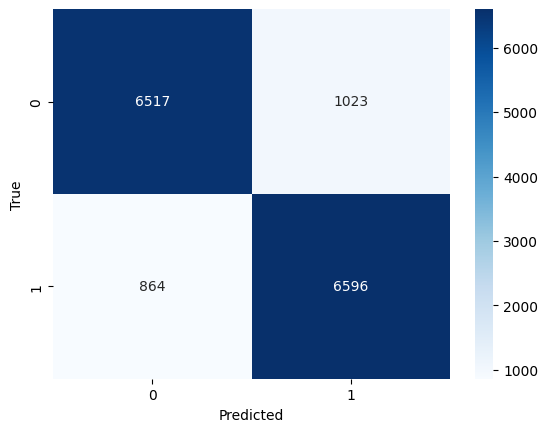

In [92]:
y_train_pred = model.predict(x_train)

y_train_bool = (y_train == 'positivo').astype(int)
y_train_pred_bool = (y_train_pred == 'positivo').astype(int)
y_test_bool = (y_test == 'positivo').astype(int)
y_test_pred_bool = (y_pred == 'positivo').astype(int)

train_score = f1_score(y_train_bool.values, y_train_pred_bool)
test_score = f1_score(y_test_bool.values, y_test_pred_bool)

print("Matriz de confusión de los datos de prueba:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [93]:
accuracy=accuracy_score(y_train_bool, y_train_pred_bool)
recall=recall_score(y_train_bool, y_train_pred_bool)
f1=f1_score(y_train_bool, y_train_pred_bool)
precision=precision_score(y_train_bool, y_train_pred_bool)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

accuracy=accuracy_score(y_test_bool,y_test_pred_bool)
recall=recall_score(y_test_bool,y_test_pred_bool)
f1=f1_score(y_test_bool,y_test_pred_bool)
precision=precision_score(y_test_bool,y_test_pred_bool)

print("\nCálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.936
Recall:  0.941
Precision:  0.932
F1 score:  0.936

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.874
Recall:  0.884
Precision:  0.866
F1 score:  0.875


## Nueva Hipótesis: Filtrar los reviews

En este TP no fue necesario analizar y filtrar la base de datos antes de crear el Bayes Naive model. Pero se pensó cuantificar qué tan negativo o positivo son los reviews y luego modificar el dataset según eso. Habría dos maneras de filtrarlo: solo tomando los reviews más extremos o solamente tomar los mas neutrales

Existe una librería llamada TextBlob para intentar lograr esto. El análisis de sentimiento de TextBlob implica el uso de un modelo de aprendizaje automático previamente entrenado para asignar una puntuación de polaridad a un fragmento de texto determinado. El modelo evalúa las palabras y frases del texto y proporciona una puntuación numérica que indica la positividad o negatividad del sentimiento.

In [95]:
from textblob import TextBlob

reviews_hip = reviews.copy()

def quantify_reviews(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity

La función quantify_reviews() agarra cada review, lo transforma en un objeto TextBlob y analiza el sentimiento del review, devolviendo un float entre -1 y 1 donde 1 es extremadamente positivo y -1 se extremadamente negativo.

Ahora se deben encontrar los thresholds optimos para probar nuestra hipótesis y saber qué reviews eliminar antes de entrenar al modelo.

In [96]:
reviews_hip['score'] = reviews_hip['review_es'].apply(quantify_reviews)

pos_threshold = 0.1
neg_threshold = -0.305
filtered_data = reviews_hip[((reviews_hip['score'] < pos_threshold) & (reviews_hip['score'] > neg_threshold))]

In [97]:
reviews_hip_x = filtered_data['review_es'].copy()
reviews_hip_y = filtered_data['sentimiento'].copy()

x_train, x_test, y_train, y_test = train_test_split(reviews_hip_x, reviews_hip_y, test_size=0.30, random_state=0)

In [98]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

Matriz de confusión de los datos de prueba:


Text(50.722222222222214, 0.5, 'True')

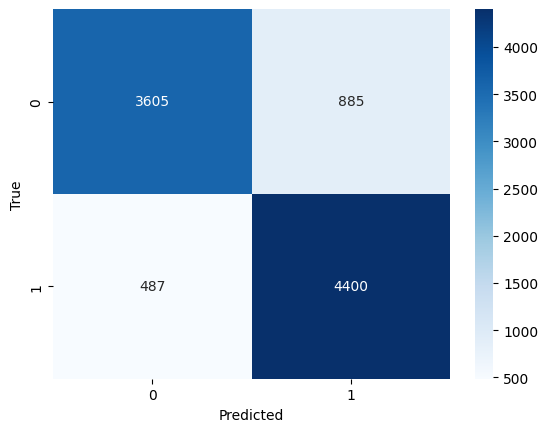

In [99]:
y_train_bool = (y_train == 'positivo').astype(int)
y_train_pred_bool = (y_train_pred == 'positivo').astype(int)
y_test_bool = (y_test == 'positivo').astype(int)
y_test_pred_bool = (y_test_pred == 'positivo').astype(int)

train_score = f1_score(y_train_bool.values, y_train_pred_bool)
test_score = f1_score(y_test_bool.values, y_test_pred_bool)

print("Matriz de confusión de los datos de prueba:")
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [100]:
accuracy=accuracy_score(y_train_bool, y_train_pred_bool)
recall=recall_score(y_train_bool, y_train_pred_bool)
f1=f1_score(y_train_bool, y_train_pred_bool)
precision=precision_score(y_train_bool, y_train_pred_bool)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

accuracy=accuracy_score(y_test_bool,y_test_pred_bool)
recall=recall_score(y_test_bool,y_test_pred_bool)
f1=f1_score(y_test_bool,y_test_pred_bool)
precision=precision_score(y_test_bool,y_test_pred_bool)

print("\nCálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.921
Recall:  0.944
Precision:  0.905
F1 score:  0.924

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.854
Recall:  0.9
Precision:  0.833
F1 score:  0.865


Luego de un probar diferentes thesholds manualmente y probar ambas maneras de filtrar, nos dio mejores resultados tomar los reviews más neutrales con un threshold de -0.305 < x < 0.1. Intentaremos probar con valores más cercanos a este threshold para conseguir un mejor resultado.

In [101]:
best_theshold = (0,0)
best_score = 0


for pos_threshold in np.arange(0.095, 0.1055, 0.0025):
    for neg_threshold in np.arange(-0.315, -0.295, 0.0025):
        #print("Threshold: " + str(neg_threshold) + " < x < " + str(pos_threshold))

        filtered_data = reviews_hip[((reviews_hip['score'] < pos_threshold) & (reviews_hip['score'] > neg_threshold))]

        reviews_hip_x = filtered_data['review_es'].copy()
        reviews_hip_y = filtered_data['sentimiento'].copy()

        x_train, x_test, y_train, y_test = train_test_split(reviews_hip_x, reviews_hip_y, test_size=0.30, random_state=0)
        
        model = make_pipeline(TfidfVectorizer(), MultinomialNB())
        model.fit(x_train, y_train)

        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)

        y_train_bool = (y_train == 'positivo').astype(int)
        y_train_pred_bool = (y_train_pred == 'positivo').astype(int)
        y_test_bool = (y_test == 'positivo').astype(int)
        y_test_pred_bool = (y_test_pred == 'positivo').astype(int)

        f1=f1_score(y_test_bool,y_test_pred_bool)

        #print("\nCálculo de las métricas en el conjunto de pruebas")
        #print("F1 score: ", round(f1, 3))

        #print("-----------------------------------------------------")

        if f1 > best_score:
            best_score = f1
            best_theshold = [neg_threshold, pos_threshold]


print("Best threshold: " + str(best_theshold[0]) + " < x < " + str(round(best_theshold[1], 3)))

Best threshold: -0.315 < x < 0.10500000000000001


In [102]:
filtered_data = reviews_hip[((reviews_hip['score'] < best_theshold[1]) & (reviews_hip['score'] > best_theshold[0]))]

reviews_hip_x = filtered_data['review_es'].copy()
reviews_hip_y = filtered_data['sentimiento'].copy()

x_train, x_test, y_train, y_test = train_test_split(reviews_hip_x, reviews_hip_y, test_size=0.30, random_state=0)

model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

Matriz de confusión de los datos de prueba:


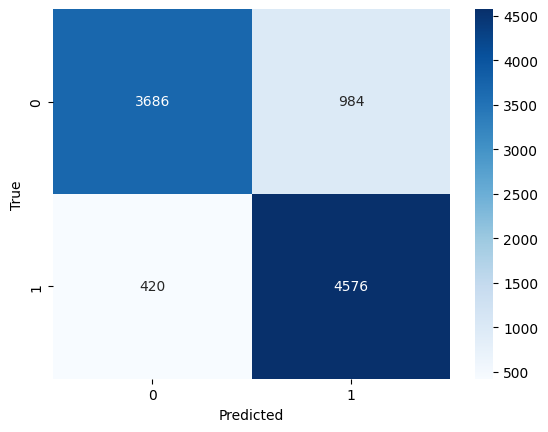

In [103]:

y_train_bool = (y_train == 'positivo').astype(int)
y_train_pred_bool = (y_train_pred == 'positivo').astype(int)
y_test_bool = (y_test == 'positivo').astype(int)
y_test_pred_bool = (y_test_pred == 'positivo').astype(int)

train_score = f1_score(y_train_bool.values, y_train_pred_bool)
test_score = f1_score(y_test_bool.values, y_test_pred_bool)

print("Matriz de confusión de los datos de prueba:")
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [104]:
accuracy=accuracy_score(y_train_bool, y_train_pred_bool)
recall=recall_score(y_train_bool, y_train_pred_bool)
f1=f1_score(y_train_bool, y_train_pred_bool)
precision=precision_score(y_train_bool, y_train_pred_bool)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

accuracy=accuracy_score(y_test_bool,y_test_pred_bool)
recall=recall_score(y_test_bool,y_test_pred_bool)
f1=f1_score(y_test_bool,y_test_pred_bool)
precision=precision_score(y_test_bool,y_test_pred_bool)

print("\nCálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.914
Recall:  0.949
Precision:  0.89
F1 score:  0.919

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.855
Recall:  0.916
Precision:  0.823
F1 score:  0.867


## Hipótesis + Grid Search

Le aplico un Grid Search a nuestro nuevo dataset filtrado.

In [105]:
filtered_data = reviews_hip[((reviews_hip['score'] < best_theshold[1]) & (reviews_hip['score'] > best_theshold[0]))]

reviews_hip_x = filtered_data['review_es'].copy()
reviews_hip_y = filtered_data['sentimiento'].copy()

x_train, x_test, y_train, y_test = train_test_split(reviews_hip_x, reviews_hip_y, test_size=0.30, random_state=0)


model = Pipeline([("tfidf", TfidfVectorizer()), ("mnb", MultinomialNB())])

params_grid = {
        'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
        'tfidf__max_features': [1000, 10000, 100000],
        'mnb__alpha': [0.001, 0.01, 0.1],
}

scorer_fn = make_scorer(f1_score, pos_label='positivo')
kfoldcv = StratifiedKFold(n_splits=5)

gridcv = GridSearchCV(estimator=model,
                      param_grid = params_grid,
                      scoring=scorer_fn,
                      cv=kfoldcv
                      )

model = gridcv.fit(x_train,y_train)

y_pred = model.predict(x_test)
score = f1_score(y_test, y_pred, pos_label='positivo')
print("Parámetros:", gridcv.best_params_, "\nF1 score: ", round(score, 3))

Parámetros: {'mnb__alpha': 0.1, 'tfidf__max_features': 100000, 'tfidf__ngram_range': (1, 2)} 
F1 score:  0.883


Matriz de confusión de los datos de prueba:


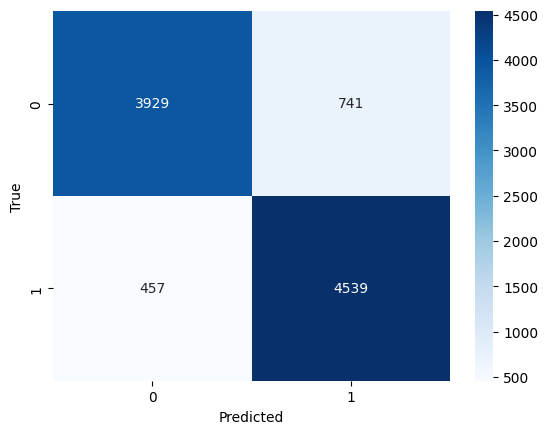

In [106]:
y_train_pred = model.predict(x_train)

y_train_bool = (y_train == 'positivo').astype(int)
y_train_pred_bool = (y_train_pred == 'positivo').astype(int)
y_test_bool = (y_test == 'positivo').astype(int)
y_test_pred_bool = (y_pred == 'positivo').astype(int)

train_score = f1_score(y_train_bool.values, y_train_pred_bool)
test_score = f1_score(y_test_bool.values, y_test_pred_bool)

print("Matriz de confusión de los datos de prueba:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [107]:
accuracy=accuracy_score(y_train_bool, y_train_pred_bool)
recall=recall_score(y_train_bool, y_train_pred_bool)
f1=f1_score(y_train_bool, y_train_pred_bool)
precision=precision_score(y_train_bool, y_train_pred_bool)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

accuracy=accuracy_score(y_test_bool,y_test_pred_bool)
recall=recall_score(y_test_bool,y_test_pred_bool)
f1=f1_score(y_test_bool,y_test_pred_bool)
precision=precision_score(y_test_bool,y_test_pred_bool)

print("\nCálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.944
Recall:  0.956
Precision:  0.935
F1 score:  0.946

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.876
Recall:  0.909
Precision:  0.86
F1 score:  0.883


## Predicción del conjunto test

In [108]:
test = pd.read_csv('test.csv')

predictions = pd.DataFrame()
predictions['ID'] = test['ID'].values
predictions['sentimiento'] = model.predict(test['review_es'])

predictions.to_csv('sample_solution.csv', index=False)